# Import modules and read data

In [1]:
import numpy as np
import pandas as pd
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation

In [2]:
# Specify data path
model_input_path = '../data/adaptive_step'
data_input_path = '../data/six_pipes'

# Get model components
superjunctions = pd.read_csv(f'{model_input_path}/superjunctions.csv')
superlinks = pd.read_csv(f'{model_input_path}/superlinks.csv')

# Read input data
Q_in = pd.read_csv(f'{data_input_path}/flow_input.csv', index_col=0)
H_bc = pd.read_csv(f'{data_input_path}/boundary_stage.csv', index_col=0)

# Create and run hydraulic model

In [5]:
superlink = SuperLink(superlinks, superjunctions, min_depth=0.0,
                      internal_links=4, auto_permute=True)

In [6]:
# Set initial timestep
dt = 300
# Create lists to store error and timestep
iters = {}

# Create simulation context manager
with Simulation(superlink, Q_in=Q_in, H_bc=H_bc) as simulation:
    # While simulation time has not expired...
    for step in simulation.steps:
        if simulation.t >= simulation.t_end:
            break
        # Step model forward in time
        simulation.step(dt=dt, num_iter=50, head_tol=0.00001)
        iters[superlink.t] = superlink.iter_elapsed
        # Record internal depth and flow states
        simulation.record_state()
        # Print progress bar
        simulation.print_progress()
        
# Convert error and timesteps to dataframes
iters = pd.DataFrame.from_dict(iters, orient='index')

[==================================================] 100.0% [0.17 s]

# Plot results

<AxesSubplot:title={'center':'Number of iterations'}>

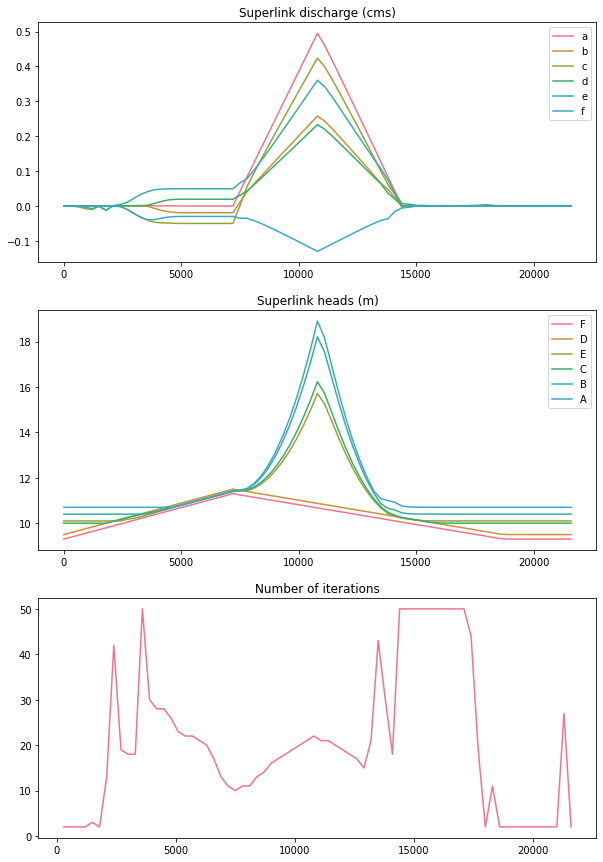

In [7]:
# Plot results
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('husl', 8)
%matplotlib inline

# Instantiate plot
fig, ax = plt.subplots(3, figsize=(10, 15))

# Compute average discharge in superlinks
simulation.states.Q_k = (simulation.states.Q_uk + simulation.states.Q_dk) / 2

# Plot results
simulation.states.Q_k.plot(ax=ax[0], title='Superlink discharge (cms)')
simulation.states.H_j.plot(ax=ax[1], title='Superlink heads (m)')
iters.plot(ax=ax[2], title='Number of iterations', legend=False)